In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.pyplot as plt
from collections import OrderedDict 
import time
import datetime
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

In [2]:
trueHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_truehits.h5"
digiHitsPath = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_digihits.h5"

trueHitsFile = h5py.File(trueHitsPath,"r")
digiHitsFile =h5py.File(digiHitsPath,"r")

#Look at event ids
n = 100000
trueEvents = trueHitsFile["event_ids"][:n]
digiEvents = digiHitsFile["event_ids"][:n]

trueEventHits = trueHitsFile["event_hits_index"][:n]
digiEventHits = digiHitsFile["event_hits_index"][:n]

print(len(trueHitsFile["event_ids"]))
print(len(digiHitsFile["event_ids"]))

print(trueEvents[:20])
print(digiEvents[:20])

print(trueEventHits[:15])

3000000
2868354
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8 10 11 13 14 15 16 17 18 19 20 21]
[    0  2590  3436  5278  8446 13937 19338 21049 25581 26876 26922 30362
 30655 30706 32859]


In [8]:
####### Generate true hits offset array and digi hits offset array

####Example (ignore)
#trueHitIndices = [0, 80, 160, 240, 320, 400, 480, 560, 640, 720, 800 ]
#digiHitIndices = [0, 100, 200, 300, 400, 500, 600, 700, 800, -1, 1000]

#Alternative method is to remove the non-matching entry from truehit -> would not have to add -1 to digiHit

#Specify number of events to run
nEvents = 100000

#Load arrays from h5 file

trueEvents = trueHitsFile["event_ids"][:nEvents]

digiEvents = digiHitsFile["event_ids"][:nEvents]

trueEventHits = trueHitsFile["event_hits_index"][:nEvents]

digiEventHits = digiHitsFile["event_hits_index"][:nEvents]

print(trueEventHits[:15])
print(digiEventHits[:15])

#Make all event_ids unique (since they reset at 3000)
#Changes them to a continous counted set (ie 1-nEvents)
digiTemp = digiEvents
for i in range(len(digiEvents)):
    
    #If next event is going to reset to 0, add 3000
    if(i != 0 and digiEvents[i] < digiEvents[i-1]):
        digiTemp[i:] = digiTemp[i:] + 3000
        
        
#Create digitized hit offset array
#Null entries are given a value of -1
#The index of the entry corresponds to its event id (ie at index 10, we get the pmt hit offset value for event 10)
digiHitsOffset = []

#Loop through trueEvents, since there are no skips
for i in range(len(trueEvents)):
    
    #Ignore - just for progress update purposes
    if(i%50000 == 0):
        print(i)
        
    #Try to find the index of the digi Event matching the true event
    try:
        index = np.where(digiTemp == i)[0][0]
        digiHitsOffset.append(digiEventHits[index]) #Append this offsetvalue to an array
    except:
        digiHitsOffset.append(-1) #Append -1 if the digi event does not exist (means it was skipped)
 
        
print(len(digiHitsOffset))
print("done")

#Uncomment this to save
np.save('Datasets/digiHitsOffsetArrNew.npy', digiHitsOffset)
        

[    0  2590  3436  5278  8446 13937 19338 21049 25581 26876 26922 30362
 30655 30706 32859]
[    0   925  1384  2506  3330  5958  7357  7738  9999 10660 11790 12012
 12990 14817 16164]
0
50000
100000
done


In [15]:
print(len(trueHitsFile["hit_pmt"]))
print(len(digiHitsFile["hit_pmt"]))

11865355642
4607347439


In [3]:
#### Run this to create list of lists #######

#Chose number of events to run
nEvents = 1000

#Load event hit indices
trueEventHits = trueHitsFile["event_hits_index"][:nEvents]
digiEventHits = digiHitsFile["event_hits_index"][:nEvents]

#Load in digitized hit offset array (created in previous step)
digiArr = np.load("Datasets/digiHitsOffsetArr.npy")
digiArr = digiArr[:nEvents]
print(len(digiArr))

#Make sure array doesnt end with -1 (will cause issues in for loop below when splicing array)
#This code reduces nEvents until the array does not end with a -1
index = len(digiArr)-1
while(index >= 0 and digiArr[index] == -1):
    digiArr = digiArr[:-1]
    nEvents -= 1
    index -= 1
    
nDigiHits = digiArr[-1]
nTrueHits = trueEventHits[nEvents-1]

print("Number of Events to save: ", nEvents)

trueEvents = trueHitsFile["event_ids"][:nEvents]
digiEvents = digiHitsFile["event_ids"][:nEvents]

trueHitPmt    = trueHitsFile["hit_pmt"][:nTrueHits]
trueHitTime   = trueHitsFile["hit_time"][:nTrueHits]
trueHitParent = trueHitsFile["hit_parent"][:nTrueHits]

digiHitPmt    = digiHitsFile["hit_pmt"][:nDigiHits]
digiHitTime   = digiHitsFile["hit_time"][:nDigiHits]
digiHitCharge = digiHitsFile["hit_charge"][:nDigiHits]

print("Looping...")

trueHitsList = []
trueHitsListLen = []

for i in range(nEvents-1):
    if(i%500 == 0):
        print("Event Progress: ",i,"/",nEvents)
    
    if(digiArr[i] == -1):
        continue
    
    checkIndex = i+1
    while(digiArr[checkIndex] == -1):
        checkIndex += 1
    
    digiStartIndex = digiArr[i]
    digiEndIndex = digiArr[checkIndex]
    
    trueStartIndex = trueEventHits[i]
    trueEndIndex = trueEventHits[i+1]
    
    splicedDigiChargeArr = digiHitCharge[digiStartIndex:digiEndIndex]
    splicedDigiPmtArr = digiHitPmt[digiStartIndex:digiEndIndex]
    splicedTruePmtArr = trueHitPmt[trueStartIndex:trueEndIndex]
    
    #print(digiArr[i],":",digiEndIndex, " ", trueEventHits[i],":",trueEventHits[i+1])
    
    for pmt in splicedDigiPmtArr:
        hits = list(np.where(splicedTruePmtArr == pmt)[0]+trueStartIndex)
        trueHitsList.append(hits)
        trueHitsListLen.append(len(hits))
        #print(len(hits),":", hits)
        

#print(trueHitsListLenArr)
#print(digiHitCharge[:100])
#print(trueHitsListLen[-100:])
print("digiHitCharge length: ",len(digiHitCharge))
print("trueHitsListLen length: ",len(trueHitsListLen))

print("Mean % error: ",round(100*np.mean((digiHitCharge-trueHitsListLen)/trueHitsListLen),3),"%")

print(trueHitsList[:10])

print(trueHitsListLen[:10])
       
'''
#Save the trueHitsList to an .npy file
trueHitsList = np.array(trueHitsList)
np.save('../Datasets/trueHitsListNew.npy', trueHitsList)
'''


1000
Number of Events to save:  1000
Looping...
Event Progress:  0 / 1000
Event Progress:  500 / 1000
digiHitCharge length:  1552423
trueHitsListLen length:  1552423
Mean % error:  4.945 %
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93], [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123], [124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 

"\n#Save the trueHitsList to an .npy file\ntrueHitsList = np.array(trueHitsList)\nnp.save('../Datasets/trueHitsListNew.npy', trueHitsList)\n"

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [11]:
trueHitsList = np.load('../Datasets/trueHitsList.npy', allow_pickle = True)
print(len(trueHitsList))
print(trueHitsListLen[:30])

NameError: name 'trueHitsList' is not defined

In [6]:
#### Test loading array ####

digiArr = np.load("digiHitsOffsetArr.npy")
digiArr = digiArr[100]

print(len(digiArr))
print(digiArr[:15])

for i in range(len(digiArr)):
    if(digiArr[i] == -1):
        pass
    
    splicedArr = 
    
    
    
    





1000000
[    0   925  1384  2506  3330  5958  7357  7738  9999    -1 10660 11790
    -1 12012 12990]


In [33]:
#Load pmt hit information from both true source and digitized source
trueHitPmt    = trueHitsFile["hit_pmt"]
trueHitTime   = trueHitsFile["hit_time"]
trueHitParent = trueHitsFile["hit_parent"]

digiHitPmt    = digiHitsFile["hit_pmt"]
digiHitTime   = digiHitsFile["hit_time"]
digiHitCharge = digiHitsFile["hit_charge"]

#Notice that there are more true hit pmts than digitized hit pmts
#This is because they do not surpass the threshold
print(len(trueHitPmt))
print(len(digiHitPmt))

11865355642
4607347439


True hit # pmts:  1458
Digitized hit # pmts:  1313
Charge Comparison:  2251 2149.814
1313


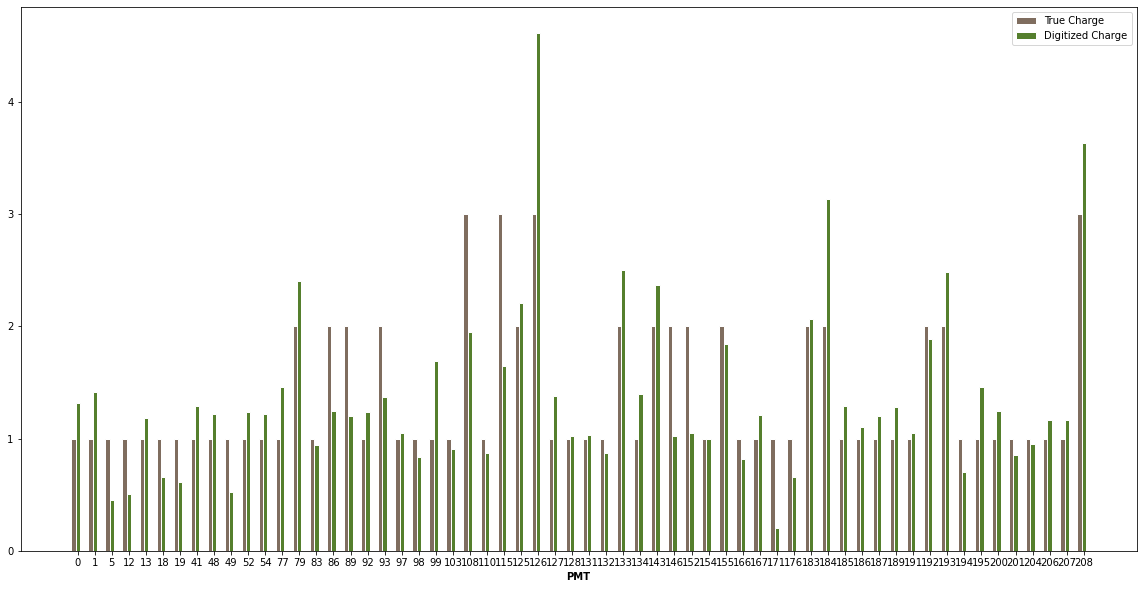

% Difference between true and digitzed charge:  28.189


In [148]:
######## Analyse a specific event ############

## NOTE: pretty sure there is a bug here, when looking for the "last event"
# there is a difference between true and digitized since digitized skips some events.
# Need to clarify this before fixing.

event = 76
#Find the starting index
digiIndex = np.where(digiEvents==event)[0][0]
trueIndex = np.where(trueEvents==event)[0][0]
startDigiIndex = digiHitsFile["event_hits_index"][digiIndex]
startTrueIndex = trueHitsFile["event_hits_index"][trueIndex]

#Find the ending true/digitize indices for each event
endDigiIndex = digiHitsFile["event_hits_index"][digiIndex+1]
endTrueIndex = trueHitsFile["event_hits_index"][trueIndex+1]

#Retrieve array of corresponding hit pmt's (indices will be different)
digiHitPmt = digiHitsFile["hit_pmt"][startDigiIndex:endDigiIndex]
trueHitPmt = trueHitsFile["hit_pmt"][startTrueIndex:endTrueIndex]
    
#Vectorized operation to count the number of instances of each unique true hit pmt there are
#This counts_elements array should very closely match up with the charge on the corresponding pmts
uniqueElements, countsElements = np.unique(trueHitPmt, return_counts=True)

#Check difference in true hit pmts vs digitized hit pmts
print("True hit # pmts: ",len(uniqueElements))
print("Digitized hit # pmts: ",len(digiHitPmt))

#Compare total charge across all pmts for true vs digitized cases
trueSum = np.sum(countsElements)
digiSum = np.sum(digiHitsFile["hit_charge"][startDigiIndex:endDigiIndex])

print("Charge Comparison: ",trueSum, digiSum)

#We can sort and intersect the arrays to find only pmts that pass the criteria for digitized hits
#Still needs work here to map correctly
intersectionArr = np.intersect1d(digiHitPmt,uniqueElements)
print(len(intersectionArr)) #We notice that this is now the same as the digitized hits, down from true pmt number

##### Create true and digi dictionaries #####
digiHitCharge = digiHitsFile["hit_charge"][startDigiIndex:endDigiIndex]

#Digitized dictionary
digiDict = dict(zip(digiHitPmt,digiHitCharge))
digiDict = dict(sorted(digiDict.items())) 
#print(digiDict)
#
#True dictionary
trueDict = dict(zip(uniqueElements,countsElements))
trueDict = {x: trueDict[x] for x in digiDict.keys()}
#print(trueDict)


##### Plotting the first n pmts from a specific event #####

# set width of bar
barWidth = 0.25
n = 60

# Set position of bar on X axis
r1 = np.arange(len(list(trueDict.values())[:n]))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.rcParams["figure.figsize"] = (20,10)
plt.bar(r1, list(trueDict.values())[:n], color='#7f6d5f', width=barWidth, edgecolor='white', label='True Charge')
plt.bar(r2, list(digiDict.values())[:n], color='#557f2d', width=barWidth, edgecolor='white', label='Digitized Charge')
 
# Add xticks on the middle of the group bars
plt.xlabel('PMT', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(list(trueDict.keys())[:n]))], list(trueDict.keys())[:n])
 
# Create legend & Show graphic
plt.legend()
plt.show()

### Calculate the mean abs error % between true and digitized hits across all common pmts ###
sumVals = 0
for pmt in trueDict.keys():
    sumVals += abs((trueDict[pmt]-digiDict[pmt])/trueDict[pmt])
diff = sumVals/len(trueDict.keys())
print("% Difference between true and digitzed charge: ", round(diff*100,3))